In [1]:
from graphviz import Digraph

def trace(root):
    #Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR == Left to Right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #For any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % ( n.label, n.data, n.grad), shape='record')
        if n._op:
            #If this value is a result of some operation, then create an op node for it
            dot.node(name = uid + n._op, label=n._op)
            #and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #Connect n1 to the node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [2]:
import math

In [3]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None #Its an empty function by default. This is what will do that gradient calculation at each of the operations.
        self._prev = set(_children)
        self._op = _op
        self.label = label


    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def backward():
          self.grad += 1.0 * out.grad   #Adding it on
          other.grad += 1.0 * out.grad  #Adding it on

        out._backward = backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def backward():
          self.grad += other.data * out.grad  #Adding it on
          other.grad += self.data * out.grad  #Adding it on

        out._backward = backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def backward():
          self.grad += 1 - (t**2) * out.grad    #Adding it on

        out._backward = backward
        return out

    def backward(self):

      topo = []
      visited = set()
      def build_topo(v):
        if v not in visited:
          visited.add(v)
          for child in v._prev:
            build_topo(child)
          topo.append(v)

      build_topo(self)

      self.grad = 1.0
      for node in reversed(topo):
        node._backward()

In [8]:
#Inputs x1, x2 of the neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#Weights w1, w2 of the neuron - The synaptic values
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#The bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

#The summation
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

#n is basically the cell body, but without the activation function
n = x1w1x2w2 + b; n.label = 'n'

#Now we pass n to the activation function
o = n.tanh(); o.label = 'o'

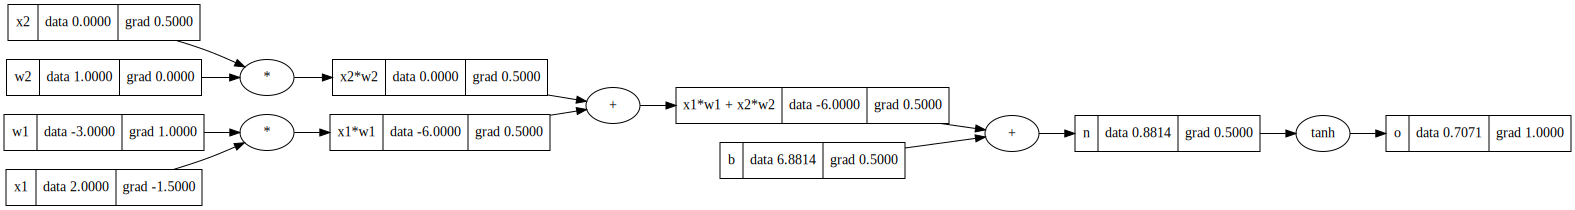

In [9]:
#o.grad = 1.0
o.backward()

draw_dot(o)

--------------------

### **Updating the Value object**

In [10]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None #Its an empty function by default. This is what will do that gradient calculation at each of the operations.
        self._prev = set(_children)
        self._op = _op
        self.label = label


    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def backward():
          self.grad += 1.0 * out.grad
          other.grad += 1.0 * out.grad

        out._backward = backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def backward():
          self.grad += other.data * out.grad
          other.grad += self.data * out.grad
        out._backward = backward
        return out

    def __rmul__(self, other):   #other * self
        return self * other

    def __truediv__(self, other):  #self/other
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):  #self - other
        return self + (-other)

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self, ), f"**{other}")

        def backward():
          self.grad += (other * (self.data ** (other - 1))) * out.grad

        out._backward = backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def backward():
          self.grad += 1 - (t**2) * out.grad

        out._backward = backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')   #We merged t and out, into just out

        def backward():
            self.grad += out.data * out.grad

        out._backward = backward
        return out

    def backward(self):

      topo = []
      visited = set()
      def build_topo(v):
        if v not in visited:
          visited.add(v)
          for child in v._prev:
            build_topo(child)
          topo.append(v)

      build_topo(self)

      self.grad = 1.0
      for node in reversed(topo):
        node._backward()

In [11]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

#o = n.tanh(); o.label = 'o'

#Spliting up of the tanh function

e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'

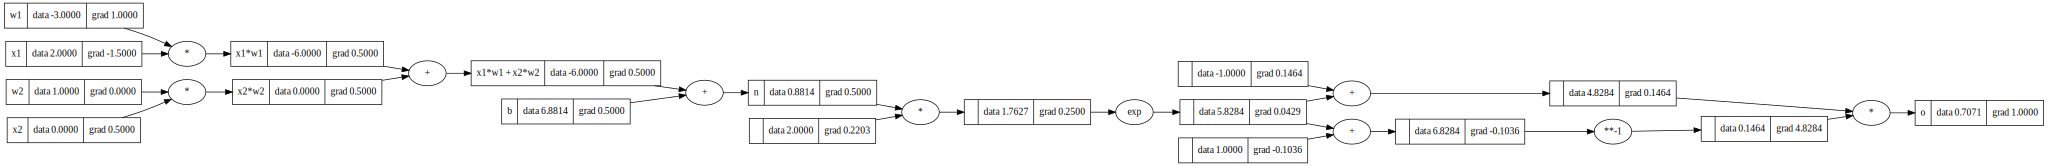

In [13]:
o.backward()

draw_dot(o)

---------------

**Hence, we have now split the tanh function and the additional operations have also been added!** \
\
**Plus, we are also getting the same output as before: o and the inputs & weights :)**